## Getting Started

The data for this exercise is a small SQLite database containing roughly a dozen tables. If you are not familiar with the SQLite database, it uses a fairly complete and standard SQL syntax, though does not many advanced analytics functions. Consider it just a remote datastore for storing and retrieving data from. 

![](db-diagram.png)

## Data Wrangling (20 minutes)

In [1]:
%reload_ext sql 
%sql sqlite:///db/sqlite/chinook.db

'Connected: None@db/sqlite/chinook.db'

In [2]:
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns 
import pandas as pd
import numpy as np
#additional imports for the models
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics as mt
from sklearn.model_selection import cross_val_score
from sklearn import metrics
%matplotlib inline

con = sqlite3.connect("db/sqlite/chinook.db")

### 1. How many different customers are there? (Example)

In [3]:
%%sql
select * from media_types;
select count(*) as count_customers, 
       count(distinct email) as count_uniq_emails
from customers;

Done.
Done.


count_customers,count_uniq_emails
59,59


or alternatively...

In [4]:
query = """
select count(*) as count_customers, 
       count(distinct email) as count_uniq_emails
from customers
"""
pd.read_sql(query, con=con)

,count_customers,count_uniq_emails
0,59,59


### 2. How long is the longest track in minutes?

In [5]:
%%sql
select trackid, printf("%.2f", max(milliseconds/1000/60)) as track_duration from tracks; 

Done.


TrackId,track_duration
2820,88.00


#### Because a minute is 60 seconds, a second is 1000 millisecs. The longest track is 88 minutes long.

### 3. Which genre has the shortest average track length?

In [6]:
%%sql
select g.name, avg(t.milliseconds)/1000/60 as avg_time
from tracks t, genres g
where t.genreid = g.genreid
group by g.name order by avg_time limit 1;

Done.


Name,avg_time
Rock And Roll,2.2440583333333333


#### Rock and Roll has the shortest average track duration among all genres

### 4. Which artist shows up in the most playlists?

In [7]:
%%sql
select ar.name, count(playlistid) 
from playlist_track p, tracks t, albums a , artists ar
where t.trackid = p.trackid
and t.albumid = a.albumid
and a.artistid = ar.artistid
group by 1 order by 2 desc limit 1;

Done.


Name,count(playlistid)
Iron Maiden,516


#### Iron Maiden, shows up in most of the playlists. Could have guessed:) 

### 5. What was the most popular album among these customers?

In [8]:
%%sql
select a.title, count(a.albumid)
from tracks t, albums a, invoice_items i
where t.albumid = a.albumid
and t.trackid = i.trackid
group by 1 order by 2 desc limit 1;

Done.


Title,count(a.albumid)
Minha Historia,27


In [9]:
%%sql

select a.title, count(playlistid) 
from playlist_track p, tracks t, albums a , artists ar
where t.trackid = p.trackid
and t.albumid = a.albumid
and a.artistid = ar.artistid
group by 1 order by 2 desc limit 1;

Done.


Title,count(playlistid)
Greatest Hits,143


#### Minha Historia is the highest purchased album. Whereas the Greatest Hits album shows up in most playlists


## Statistics & Predictive Modelling (20 minutes)

### 1. What is the correlation between the length of a track and its price?

In [10]:
track_facts = pd.read_csv("db/csv/track_facts.csv")

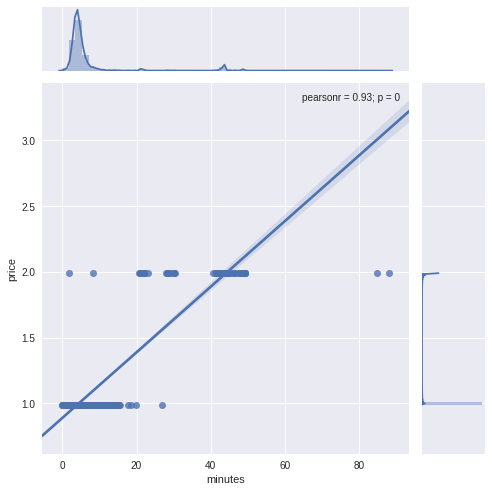

In [11]:
sns.set(rc={'figure.figsize':(18,12)})
sns.jointplot(x='minutes', y='price',  data=track_facts, size=7,kind="reg")

#### It was interesting to see that there are only thow prices for tracks, \$.99 or \$1.99. There is a strong positive correlation between price of a track and its length. Most of the tracks are priced .99 and are well under 10 minues. Another observation here, most tracks priced at 1.99 are lengthy(>20 minutes), do they represent tv_shows, comedy tracks, plays etc? and thus priced higher?

.

.

### 2. Do any seasonal patterns occur in purchases (invoices)?

#### To answer this question, first we need to resample data for different units of time, specifically here, I explored weekly, daily, and monthly patterns. 

In [12]:
orders = pd.read_csv("db/csv/orders.csv")
orders["invoice_date"] = pd.to_datetime(orders.invoice_date) ## resample on week, month and day for analysis
orders["month"] = orders["invoice_date"].dt.strftime('%b')
orders["week"] = orders["invoice_date"].dt.week

#### After, some experimentation around the differencing parameter I was able to seperate the noise from the patter. The pattern here is quite obvious. For around 3-4 months in a year there is a spike in sale, which is well above the mean.
#### The pattern seems to be moving ahead with time over time, with increase in sale in first quarter to the pattern shifting to mid year and then to end of the year by 2013

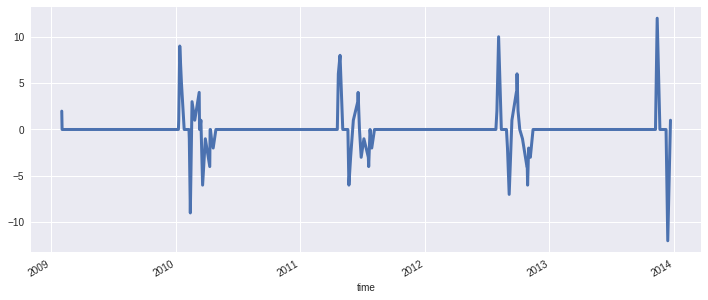

In [13]:
ts = orders.groupby(by="invoice_date").sum().reset_index().sort_values(by="invoice_date")
ts.index = ts.invoice_date # Create a time series with date as index and sale on that day as observation
sns.set(color_codes=True) 
ts.drop("invoice_date", inplace=True, axis=1)
ts["sales"].diff(6).plot(figsize=(12,5), linewidth=3, fontsize=10)
plt.xlabel('time', fontsize=10);

/home/raz/anaconda3/lib/python3.6/site-packages/pandas/core/indexes/base.py:1743: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return getitem(key)


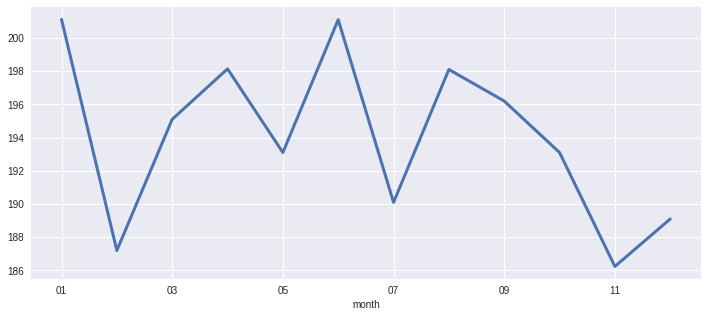

In [14]:
orders["month"] = orders["invoice_date"].dt.strftime('%m')
tsm  = orders.groupby(by="month").sum().reset_index().sort_values(by="month")
tsm.index = tsm.month
sns.set(color_codes=True)
tsm.drop("month", inplace=True, axis=1)
tsm["sales"].plot(figsize=(12,5), linewidth=3, fontsize=10)
plt.xlabel('month', fontsize=10);

#### While exploring the monthly resampled data, an observable upward trend around summer is seen. With January again starting with a high sale. 

#### Weekly resampling does not reveal anything new, but supports the previous observation about higher sales around middle of the year and start of the year.

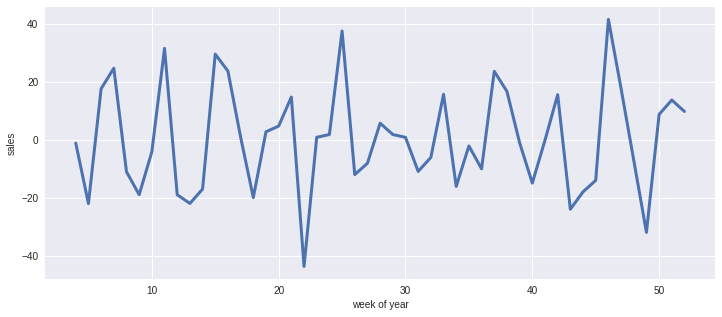

In [15]:
ts  = orders.groupby(by="week").sum().reset_index().sort_values(by="week")
ts.index = ts.week
sns.set(color_codes=True)
ts.drop("week", inplace = True, axis=1)
ts["sales"].diff(3).plot(figsize=(12,5), linewidth=3, fontsize=10)
plt.xlabel('week of year', fontsize=10);
plt.ylabel('sales', fontsize=10);

### 3. How would you tell whether a new Rock song is an outlier in terms of track length?
*use track_facts*


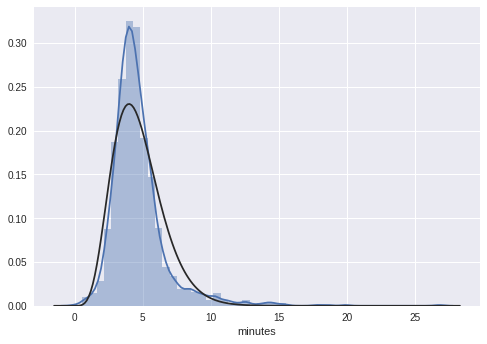

In [16]:
track_facts = pd.read_csv("./db/csv/track_facts.csv")
track_r = track_facts[track_facts["genre"] == "Rock" ]["minutes"]
from scipy import stats
sns.distplot(track_r, fit=stats.gamma)

#### Looking at the data distribution always helps in analysis, here the density plot shows a distribution of values which can be approximated to a normal distribution. With a skew towads right, with a mean of 4.68. 
#### Thus, properties of normal distribution can be used here. i.e About 95% of the observations will fall within 2 standard deviations of the mean, which is the interval (-2,2) for the standard normal, and about 99.7% of the observations will fall within 3 standard deviations of the mean. 
#### We can use the mean +- 3 \** std. deviation* as a cutoffs to filter outliers.
#### With some tuning to compensate for the skew

In [17]:
mean = np.mean(track_r, axis=0)
sd = np.std(track_r, axis=0)
print("Mean is {1} with Std. Deviation of {0}, lower outliers cutoff {2} and upper outlier cutoff {3}".format(sd,mean, (mean - (1.8 * sd)), (mean + (2.5 * sd))))
final_list = [x for x in track_r if (x < (mean - (1.8 * sd)))]
final_list += [x for x in track_r if (x > (mean + (3 * sd)))]
print(sorted(final_list))

Mean is 4.682420971472628 with Std. Deviation of 2.112166759042186, lower outliers cutoff 0.8805208051966931 and upper outlier cutoff 9.962837869078093
[0.0, 0.6, 0.7, 0.7, 0.8, 0.8, 11.1, 11.1, 11.2, 11.3, 11.6, 11.8, 11.8, 12.4, 12.4, 12.6, 12.7, 12.7, 13.4, 13.7, 14.1, 14.2, 14.3, 14.6, 14.7, 15.2, 15.5, 17.8, 18.6, 19.9, 26.8]


#### We can similarly update and check if a new song false in 0.3% extreme ends of the distribution. And mark it as an outlier, for example currently we have 0.0 to 0.8 minute and above 11 minute lenth songs are marked as outliers. 

#### As for another approach, we could also use Inter quartile range here.

### 4. We want to build a recommendation service for our customers. 

* What features might be important for predicting whether a customer is likely to purchase a track? 
* Create a simple model based on those features and evaluate it's performance. 
* How much did those features individually contribute to the predictions of your model?
* How would you explain your model to a Product Manager? To the Sales team?
* What next steps would you take to improve the predictive performance of your model?

For this experiment I thought two approaches, first from the business perspective finding the signature of a successful track could be important. This could help giving some idea on where to maximize efforts, in terms the inventory. For example, what artists to bring on platform, what genres are popular among users, what media to use for song delivery etc. I created a dataset around this hypothesis, which for a given track has following attributes, which I assumed play important role in purchase decision. Length of a track, price, popularity(how many playlists it is a part of), was_there_a_sale, top_artist(is the artist among n top most heard artist), what genre it belongs to, what media type is used



In [18]:
query = """
select  t.trackid as tid, t.mediatypeid as media, g.name as genre, t.milliseconds/1000 as length, t.unitprice as price , appr.cnt as popularity,sold.sale as sold,
        case WHEN a.artistid in
        (select aid from 
            (select ar.artistid as aid , count(playlistid) 
            from playlist_track p, tracks t, albums a , artists ar
            where t.trackid = p.trackid
            and t.albumid = a.albumid
            and a.artistid = ar.artistid
            group by 1 order by 2 desc limit 100) as df) then 1 ELSE 0
        END as top_artist 
from tracks t
LEFT OUTER JOIN albums a ON(t.albumid = a.albumid)
LEFT OUTER JOIN genres g ON ( t.genreid = g.genreid)
LEFT OUTER JOIN 
  (select t.trackid as tid, count(playlistid) as cnt
        from playlist_track p, tracks t, albums a , artists ar
        where t.trackid = p.trackid
        and t.albumid = a.albumid
        and a.artistid = ar.artistid
        group by 1)
        as appr ON (t.trackid = appr.tid)
LEFT OUTER JOIN
        (select t.trackid as tid, count(i.invoiceid) as sale
        from tracks t, albums a, invoice_items i
        where t.albumid = a.albumid
        and t.trackid = i.trackid
        group by 1)
        as sold ON (t.trackid = sold.tid)
"""

mdata = pd.read_sql(query, con=con)
mdata = mdata.fillna(0)
mdata = pd.get_dummies(mdata , columns=["genre","media"])
mdata.index = mdata["tid"]
mdata.drop("tid", inplace = True, axis=1)

mdata.loc[mdata["sold"] !=0, "sold"] = 1 # if there was a sale then 1 else 0 

y = mdata["sold"]
mdata.drop("sold", inplace=True, axis=1)
X = mdata
X.head()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2111)

             precision    recall  f1-score   support

        0.0       0.53      0.18      0.27       353
        1.0       0.62      0.89      0.73       523

avg / total       0.58      0.61      0.54       876

[[ 64 289]
 [ 57 466]]


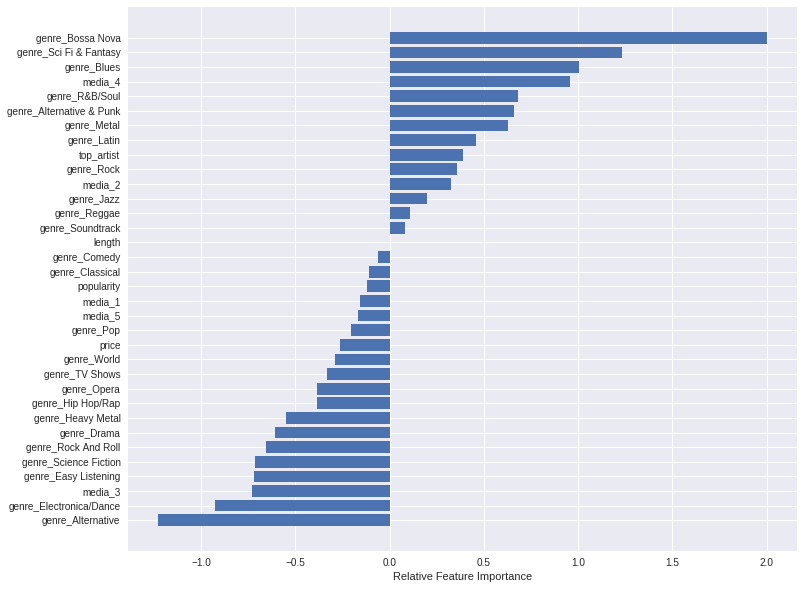

In [19]:
from sklearn.linear_model import LogisticRegression

lg = LogisticRegression()
lg.fit(X_train, y_train)

y_pred = lg.predict(X_test)
print(metrics.classification_report(y_test, y_pred))
print(metrics.confusion_matrix(y_test, y_pred))

feature_importance = (lg.coef_[0])

feature_importance = 2 * (feature_importance/max(feature_importance))
sorted_idx = np.argsort(feature_importance)

pos = np.arange(sorted_idx.shape[0]) + .7
#print(list(zip(np.array(X.columns)[sorted_idx], feature_importance[sorted_idx] )))

featfig = plt.figure(figsize=(12, 10))
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X.columns)[sorted_idx], fontsize=10)
featax.set_xlabel('Relative Feature Importance')

plt.show()

The logistic regression did pretty well for a priliminary model.

### Explaination
 The simplest explaination from the plot above is to maximize the features that are positive (towards right). Since these feature have a positive correlation with target variable. 
 For example, an actionable insight here could be to bring more top artist on platform, bring more tracks from genre Rock, 
 While lowering the resources on the negative factors, or investigating why the factors have a negative correlation with a purchase


In [20]:
rclf = RandomForestClassifier(n_estimators=500, random_state=2111, n_jobs=-1, max_depth=3)
rclf.fit(X_train, y_train)
scores = cross_val_score(rclf, X_train, y_train, cv=5)
print(scores)
ypred = rclf.predict(X_test)
print("Accuracy: %0.2f (+/- %0.2f)\n" % (scores.mean(), scores.std() * 2))

print(mt.classification_report(y_test, ypred))
print(mt.confusion_matrix(y_test, ypred))

[ 0.54459203  0.53904762  0.55809524  0.5447619   0.55619048]
Accuracy: 0.55 (+/- 0.01)

             precision    recall  f1-score   support

        0.0       0.58      0.06      0.11       353
        1.0       0.61      0.97      0.75       523

avg / total       0.59      0.60      0.49       876

[[ 22 331]
 [ 16 507]]


#### Both the models have a very high recall for the true class, with an average precision. These models are able to flag the potential customers but could not seperate them well. A little tuning could improve this.

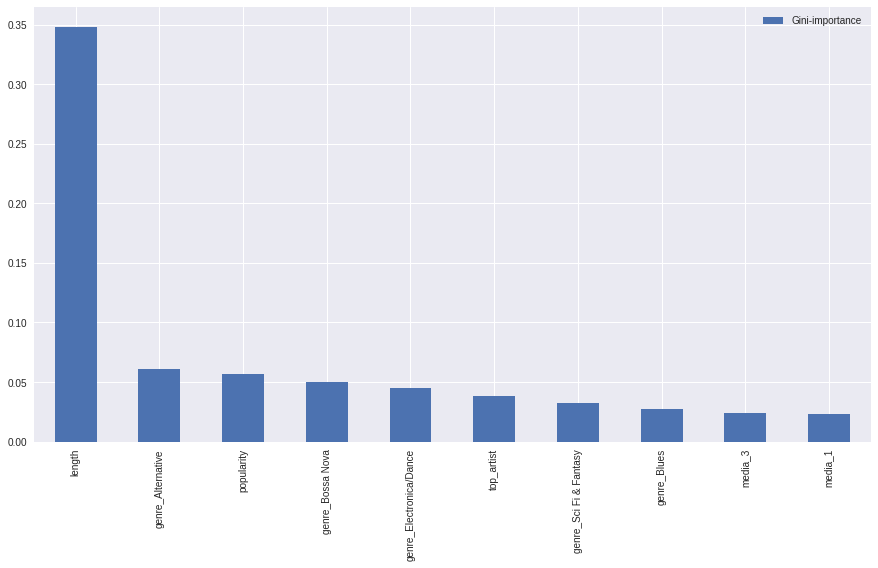

In [21]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X.columns, rclf.feature_importances_):
    feats[feature] = importance #add the name/value pair
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance', ascending=False).iloc[:10,:].plot(kind="bar", figsize=(15,8))

 I took another pass at this problem, to find important feature irrespective of their (positive/negative) correlation to to purchase. 
 This gives product team/sales team top n things to work on. The correlation can be easily worked out with a little investigation. 
 Here, we can see the popularity is one of top features, so is top artist along with length and genre. 
 Lengthier tracks tend to be paid, so that has an effect here. 
 There is a noise factor, not all features that show up in above models are causing customers to buy/not buy a track. They Simply state correlation. For example, great bossa nova tracks might be most/all paid, thus show up in models. 

### Recommendation Engines
Second approach, 

Since we need a recommender service, we could create a item-item or user-item similarity recommender to capture patterns in similar users or artists, to suggest users better artists which match their taste and the track they are currently listening to thus driving engagement/sale higher. 
For this, dataset with a user and all the artists user has listened to was extracted and later transformed for different approaches.

 59 Users, 166 Artists 

In [22]:
query = """
select c.customerid as cid , AR.name  as artist_name
from customers C INNER JOIN invoices I ON (C.customerId = I.customerId)
                 INNER JOIN invoice_items IT ON (IT.InvoiceId = I.InvoiceId)
                 INNER JOIN tracks T ON (T.TrackId = IT.TrackId)
                 INNER JOIN albums A ON (T.AlbumId = A.AlbumId)
                 INNER JOIN artists AR ON (AR.ArtistId = A.ArtistId) """

mata = pd.read_sql(query, con=con)
orig = mata.groupby(by=["cid","artist_name"]).size().unstack().fillna(0).reset_index()
data_items = orig.copy()

n_users = data_items.cid.unique().shape[0]
n_items = data_items.columns.unique().shape[0]
print('Number of users = ' + str(n_users) + ' | Number of Artists = ' + str(n_items))

train_data, test_data = train_test_split(data_items, test_size=0.10,  random_state=2111)

Number of users = 59 | Number of Artists = 166


In [23]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mean_squared_error
from math import sqrt

# As a first step we normalize the user vectors to unit vectors.
magnitude = np.sqrt(np.square(train_data).sum(axis=1))
magnitude_ts = np.sqrt(np.square(test_data).sum(axis=1))

# unitvector = (x / magnitude, y / magnitude, z / magnitude, ...)
train_data = train_data.divide(magnitude, axis='index')
test_data = test_data.divide(magnitude_ts, axis='index')

def calculate_similarity(data_items):
    """Calculate the column-wise cosine similarity for a sparse
    matrix. Return a new dataframe matrix with similarities.
    """
    data_sparse = sparse.csr_matrix(train_data)
    similarities = cosine_similarity(data_sparse.transpose())
    sim = pd.DataFrame(data=similarities, index=data_items.columns,
                       columns=train_data.columns)
    return sim

# Build the similarity matrix
train_data_matrix = calculate_similarity(train_data)
test_data_matrix = calculate_similarity(test_data)


# Lets get the top 11 similar artists for Aerosmith
print(train_data_matrix.loc['Aerosmith'].nlargest(11)[1:])

artist_name
Faith No More         0.871031
The Rolling Stones    0.840623
The Doors             0.752745
The Tea Party         0.747421
Marvin Gaye           0.677455
The Police            0.605904
Smashing Pumpkins     0.570715
The Cult              0.457011
AC/DC                 0.367100
The Who               0.302893
Name: Aerosmith, dtype: float64


#.

For example, if an user is listening to Aerosmith, recommender can suggest other matching artists, the above output gives to 10 closest artist with similarity scores. 
For Example: Rolling Stones is a match to Aerosmith with .84 similarity score. 

In [24]:
# Construct a new dataframe with the 10 closest neighbours (most similar)
# for each artist.

train_data.cid = orig.cid  #reset cid 

def  get_recom(data_matrix, train_data, user):
    data_neighbours = pd.DataFrame(index=train_data_matrix.columns, columns=range(1,11))
    for i in range(0, len(train_data_matrix.columns)):
        data_neighbours.iloc[i,:10] = data_matrix.iloc[0:,i].sort_values(ascending=False)[:10].index
    
    user_index = train_data[train_data.cid == user].index.tolist()[0]
    # Get the artists the user has played.
    known_user_likes = train_data.loc[user_index]
    known_user_likes = known_user_likes[known_user_likes >0].index.values[1:]

    # Construct the neighbourhood from the most similar items to the
    # ones our user has already liked.
    most_similar_to_likes = data_neighbours.loc[known_user_likes]
    similar_list = most_similar_to_likes.values.tolist()
    similar_list = list(set([item for sublist in similar_list for item in sublist]))
    neighbourhood = train_data_matrix[similar_list].loc[similar_list]

    # A user vector containing only the neighbourhood items and
    # the known user likes.
    user_vector = train_data.loc[user_index].loc[similar_list]

    # Calculate the score.
    score = neighbourhood.dot(user_vector).div(neighbourhood.sum(axis=1))

    # Drop the known likes.
    score = score.drop(known_user_likes)
    return score, known_user_likes

score,known_user_likes  = get_recom(train_data_matrix, train_data,21)

print("Users Existing Likes\n\n", known_user_likes)
print("Suggested_Artists\n\n", score.nlargest(10)[1:]) #because First column is cid

Users Existing Likes

 ['Amy Winehouse' 'Antônio Carlos Jobim' 'Cidade Negra' 'Cláudio Zoli'
 'Frank Zappa & Captain Beefheart' 'Green Day' "Guns N' Roses" 'Incognito'
 'Led Zeppelin' 'Marcos Valle' 'Os Paralamas Do Sucesso' 'Ozzy Osbourne'
 'Page & Plant' 'Passengers' 'U2' 'Various Artists']
Suggested_Artists

 artist_name
Berliner Philharmoniker & Hans Rosbaud           0.066184
Kiss                                             0.054498
Berliner Philharmoniker & Herbert Von Karajan    0.042804
System Of A Down                                 0.042312
The 12 Cellists of The Berlin Philharmonic       0.041422
Olodum                                           0.036597
Elis Regina                                      0.033373
Lost                                             0.029595
Paul D'Ianno                                     0.029132
dtype: float64


#### Here we are using all the songs that user has listened to to predict next closest match or to genrate recommendation. This approach is more personalized

### Improvements
* Extract more features, the features used in classifier models were limited and thus resulted in weaker models. With hypothesis tests.
* The models could be tuned for better results, adjusting thresholds could improve the model performance here
* It could also help if we could gather more data and use it to train the models, for recommendation models this could be a great improvement.
* Hyperparameter tuning for ensemble models 
* Validate recommender models by calculating recommendations RMSE for the test data 

## Data Visualization (10 minutes)

### 1. Prepare a plot(s) that effectively illustrates the variation of track length by genre.
*use track_facts*

/home/raz/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


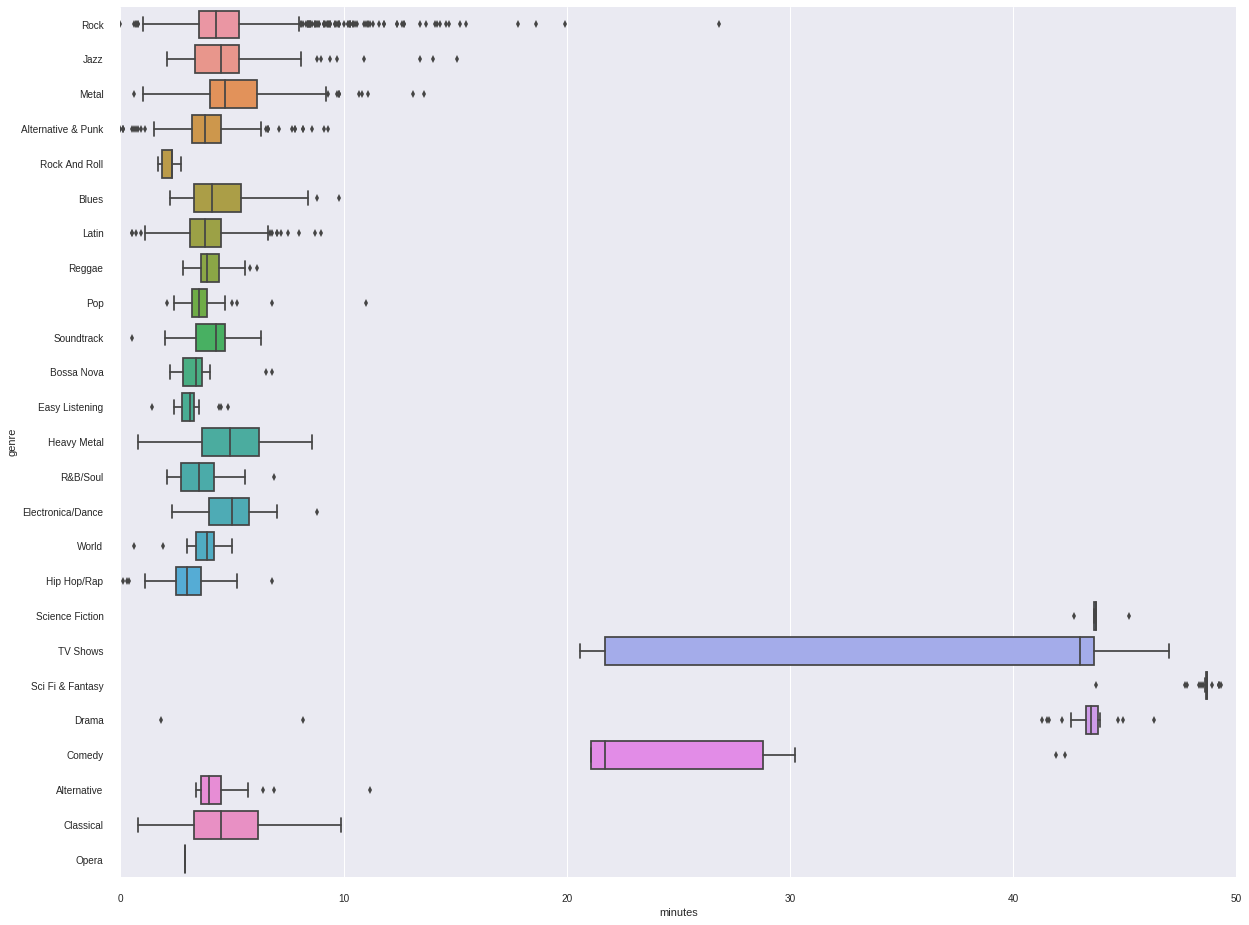

In [25]:
import seaborn as sns
sns.set(style="ticks")
sns.set(rc={'figure.figsize':(20,16)})
plt.xlim(xmin=0,xmax=50)
sns.set(rc={'figure.figsize':(18,8)})
# Draw a nested boxplot to show bills by day and sex
sns.boxplot(y="genre", x="minutes", data=track_facts)
sns.despine(offset=10, trim=True)

#### This plot gives most information in a glance for relationship between genres and track length.
#### For example, we can see that there are not many tracks in Opera and Drama genre . Also TV-Shows are the lengthiest. etc.
#### along with some idea about outliers

### 2. Prepare a plot(s) that summarizes sales by month. 
*use orders*
*Bonus opportunity: add a trend line.*

In [26]:
orders = pd.read_csv("db/csv/orders.csv")
orders["invoice_date"] = pd.to_datetime(orders.invoice_date)
orders["mmyy"] = orders["invoice_date"].dt.strftime("%m")
orders = orders.sort_values("mmyy") 

tsm = orders.groupby("mmyy").sum().reset_index()
#orders.drop(["level_0", "index", "invoice_date"])

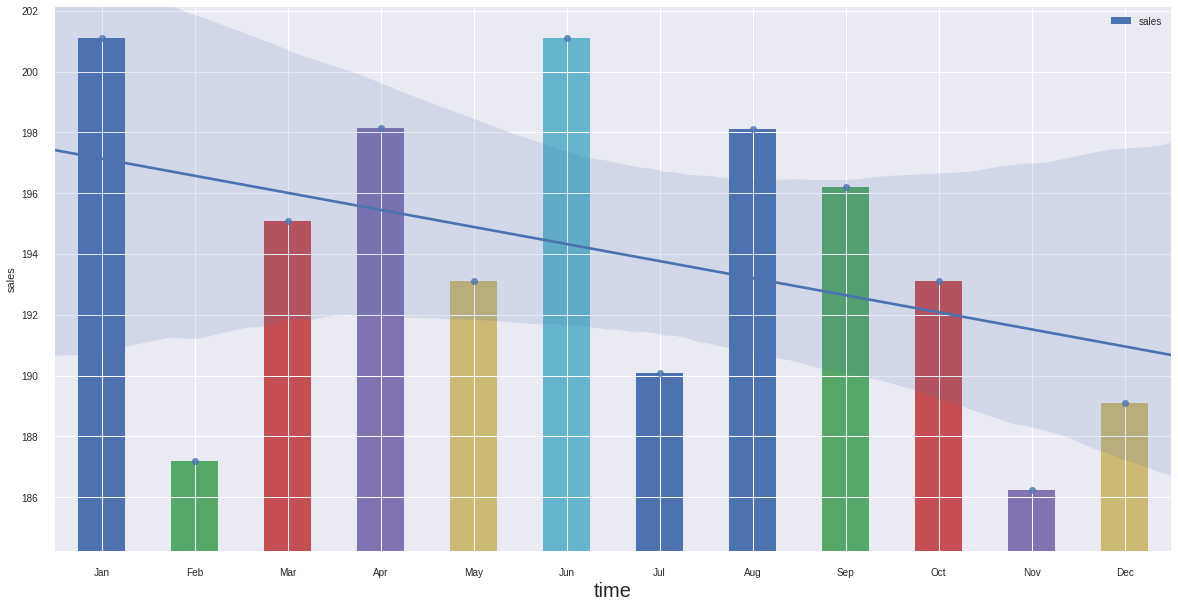

In [27]:
look_up = {'01': 'Jan', '02': 'Feb', '03': 'Mar', '04': 'Apr', '05': 'May',
            '06': 'Jun', '07': 'Jul', '08': 'Aug', '09': 'Sep', '10': 'Oct', '11': 'Nov', '12': 'Dec'}

tsm["mmyy"] = tsm["mmyy"].apply(lambda x: look_up[x])

sns.set(color_codes=True)
ax = tsm.plot(x="mmyy", y = "sales", figsize=(20,10), linewidth=5, fontsize=20, kind="bar")
plt.ylim(ymin=np.min(tsm.sales)-2,ymax=np.max(tsm.sales)+1)
plt.xlabel('time', fontsize=20);

# put bars in background:
for c in ax.patches:
    c.set_zorder(0)
# plot regplot with numbers 0,..,len(a) as x value
sns.regplot(x=np.arange(0,len(tsm)), y=tsm.sales, ax=ax)
sns.despine(offset=10, trim=False)
plt.show()

#### There are some noticeable patterns here, we can see that sale are highest at the start of year, falling down immedietly and again picking up during mid of the year. Overall Following a downward trend.

#### 3. Take a look at the following plot from the Economist on the relationship between corruption and development of countries. 

![](https://cdn.static-economist.com/sites/default/files/20111210_WOC210.gif)

**What aspects of the plot work well?** 

The graph depicts the relationship between HDI and Corruption index pretty well. The random labels for points on graph help illustrate the purpose of graph well. Outliers are labeled. 

It Also gives the R^2 value for over all relationship. Which helps understanding the magnitude of relationship.


**What would you change about it to be more effective?**

The graph has significant cluter, apart from the labeled points other points do not carry much information. Instead, the points could have been grouped to represent number of countries that correspond to that group/location and break down outliers in multiple points. 

To understand the relationship better, it would have been interesting to see how the relationship changes over time. If the recent economic developments have changed the corruption levels. 

Does a nation's perception of corruption changes over time. For example, lobbying laws are fairly new and exist mostly in developed countries where as in underdeveloped countries this could be labeled as corruption. 

The another issue is the X-axis, the second glance could have been avoided by using rankings on corruption index instead of 10=being least corrupt.

#### references
https://www.ics.uci.edu/~welling/teaching/CS77Bwinter12/presentations/course_Ricci/13-Item-to-Item-Matrix-CF.pdf

https://cambridgespark.com/content/tutorials/implementing-your-own-recommender-systems-in-Python/index.html

https://seaborn.pydata.org/generated/seaborn.regplot.html

https://medium.com/@victorkohler/als-implicit-collaborative-filtering-5ed653ba39fe

https://github.com/MrChrisJohnson/implicit-mf/blob/master/mf.py
